## 📅 Day 4: Training Loop Basics

In [136]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
            nn.ReLU(),
            nn.Linear(2, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [137]:
import torch
import torch.optim as optim

x = torch.randn(100, 2)
y = (x[:, 0] + x[:, 1] > 0).float().unsqueeze(1)

model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# minimal training loop
for epoch in range(10):
    optimizer.zero_grad()
    pred = model(x)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.7358
Epoch 1, Loss: 0.7329
Epoch 2, Loss: 0.7299
Epoch 3, Loss: 0.7269
Epoch 4, Loss: 0.7239
Epoch 5, Loss: 0.7208
Epoch 6, Loss: 0.7176
Epoch 7, Loss: 0.7142
Epoch 8, Loss: 0.7106
Epoch 9, Loss: 0.7067


In [138]:
# 🧠 Homework:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=2000, n_features=16, 
                           n_classes=2, n_informative=10, random_state=42)

In [139]:
y.shape

(2000,)

In [140]:
class oneResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(16, 64, bias=False),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 16)
        )
        self.final = nn.Sequential(
            nn.LayerNorm(16),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        y = self.layers(x) + x
        y = self.final(y)
        return y

In [141]:
model = oneResidualBlock()
# - Implement same training loop with SGD
optimizer = optim.SGD(model.parameters(), lr=0.01)
# - Try MSELoss and compare with BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()
criterion2 = nn.MSELoss()

In [142]:
model(torch.from_numpy(X).float()).shape

torch.Size([2000, 1])

In [143]:
torch.from_numpy(y).unsqueeze(dim=1).shape

torch.Size([2000, 1])

In [144]:
def get_batches(X, y, batch_size):
    n_samples = X.shape[0]
    indices = torch.randperm(n_samples)  # shuffle indices
    for start in range(0, n_samples, batch_size):
        end = start + batch_size
        batch_idx = indices[start:end]
        yield torch.from_numpy(X[batch_idx]).float(), torch.from_numpy(y[batch_idx]).unsqueeze(dim=1).float(), end

In [145]:
def training_loop(X, y, batch_size, model, optimizer, criterion):
    size = X.shape[0]
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_examples = 0
    for Xb, yb, current_batch in get_batches(X, y, batch_size): 
        # Call optimizer.zero_grad() to reset the gradients of model parameters.
        optimizer.zero_grad()
        prediction = model(Xb)
        loss = criterion(prediction, yb)
        bsz = yb.shape[0]
        total_examples += bsz
        total_loss += loss.item() * bsz
        total_correct += ((torch.sigmoid(prediction)>=0.5)==yb).float().sum().item()
        # Backpropagate the prediction loss with a call to loss.backward(). 
        loss.backward()
        # Once we have our gradients, we call optimizer.step() to adjust the parameters by the gradients collected in the backward pass.
        optimizer.step()
        if current_batch % 10 == 0:
            print(f"loss: {loss.item():>7f}  [{current_batch:>5d}/{size:>5d}]")
    return total_loss/total_examples, total_correct/total_examples

In [146]:
def evaluation_loop(X, y, batch_size, model, criterion):
    model.eval()
    total_loss, total_examples, correct = 0.0, 0, 0
    with torch.no_grad():
        for Xb, yb, _ in get_batches(X, y, batch_size): 
            prediction = model(Xb)
            loss = criterion(prediction, yb)
            bsz = yb.shape[0]
            total_loss += loss.item() * bsz
            probs = torch.sigmoid(prediction)
            preds = (probs >= 0.5).float()
            correct += (preds == yb).sum().item()
            total_examples += bsz
    test_loss = total_loss / total_examples
    correct /= total_examples
    # - Log both loss and accuracy
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

In [147]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [148]:
epochs=50
loss_history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_train, accuracy_train = training_loop(X_train, y_train, 32, model, optimizer, criterion)
    loss_epoch, accuracy_epoch = evaluation_loop(X_test, y_test, 32, model, criterion)
    loss_history["train_loss"].append(loss_train)
    loss_history["train_acc"].append(accuracy_train)
    loss_history["val_loss"].append(loss_epoch)
    loss_history["val_acc"].append(accuracy_epoch)

Epoch 1
-------------------------------
loss: 0.824267  [  160/ 1340]
loss: 0.760193  [  320/ 1340]
loss: 0.675250  [  480/ 1340]
loss: 0.774305  [  640/ 1340]
loss: 0.792612  [  800/ 1340]
loss: 0.756441  [  960/ 1340]
loss: 0.695040  [ 1120/ 1340]
loss: 0.669661  [ 1280/ 1340]
Test Error: 
 Accuracy: 54.8%, Avg loss: 0.708965 

Epoch 2
-------------------------------
loss: 0.727634  [  160/ 1340]
loss: 0.660998  [  320/ 1340]
loss: 0.634464  [  480/ 1340]
loss: 0.599147  [  640/ 1340]
loss: 0.661085  [  800/ 1340]
loss: 0.659363  [  960/ 1340]
loss: 0.628553  [ 1120/ 1340]
loss: 0.636347  [ 1280/ 1340]
Test Error: 
 Accuracy: 60.6%, Avg loss: 0.652700 

Epoch 3
-------------------------------
loss: 0.639629  [  160/ 1340]
loss: 0.664002  [  320/ 1340]
loss: 0.600467  [  480/ 1340]
loss: 0.587245  [  640/ 1340]
loss: 0.640111  [  800/ 1340]
loss: 0.611086  [  960/ 1340]
loss: 0.606287  [ 1120/ 1340]
loss: 0.583021  [ 1280/ 1340]
Test Error: 
 Accuracy: 66.1%, Avg loss: 0.609295 

Epoc

In [149]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    """
    history: dict containing lists per epoch
      e.g. {"train_loss": [...], "val_loss": [...], "train_acc": [...], "val_acc": [...]}
    """

    epochs = range(1, len(history["train_loss"]) + 1)

    # --- Loss plot ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Accuracy plot (optional) ---
    if "train_acc" in history and "val_acc" in history:
        plt.figure(figsize=(6,4))
        plt.plot(epochs, history["train_acc"], label="Train Acc")
        plt.plot(epochs, history["val_acc"], label="Val Acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Training vs Validation Accuracy")
        plt.legend()
        plt.grid(True)
        plt.show()

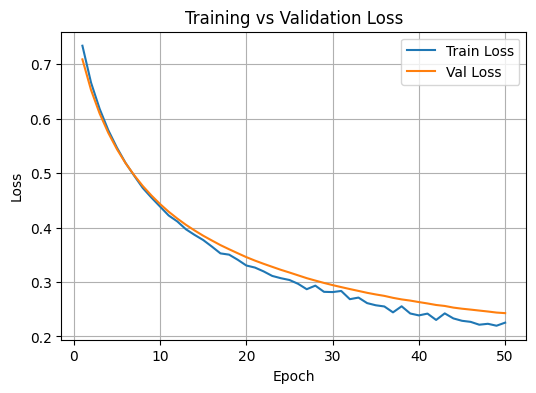

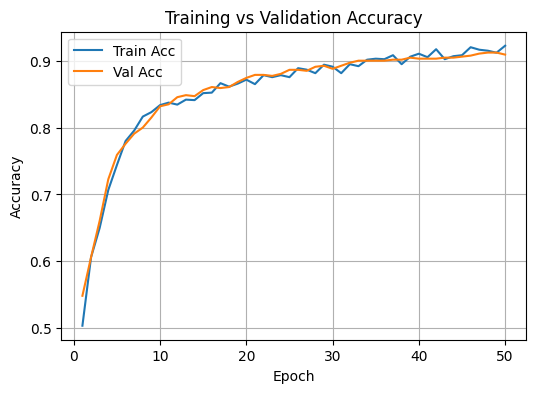

In [150]:
plot_training_curves(loss_history)

In [151]:
# - Explore learning rate effects (0.1, 0.001)
def train_and_plot(lr,epochs, batch_size):
    model = oneResidualBlock()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    loss_history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        loss_train, accuracy_train = training_loop(X_train, y_train, batch_size, model, optimizer, criterion)
        loss_epoch, accuracy_epoch = evaluation_loop(X_test, y_test, batch_size, model, criterion)
        loss_history["train_loss"].append(loss_train)
        loss_history["train_acc"].append(accuracy_train)
        loss_history["val_loss"].append(loss_epoch)
        loss_history["val_acc"].append(accuracy_epoch)
    
    # - Plot loss vs epoch
    plot_training_curves(loss_history)
    return loss_history

Epoch 1
-------------------------------
loss: 0.624526  [  160/ 1340]
loss: 0.613427  [  320/ 1340]
loss: 0.522699  [  480/ 1340]
loss: 0.564487  [  640/ 1340]
loss: 0.584447  [  800/ 1340]
loss: 0.490593  [  960/ 1340]
loss: 0.462850  [ 1120/ 1340]
loss: 0.404519  [ 1280/ 1340]
Test Error: 
 Accuracy: 83.9%, Avg loss: 0.419887 

Epoch 2
-------------------------------
loss: 0.519962  [  160/ 1340]
loss: 0.558503  [  320/ 1340]
loss: 0.345324  [  480/ 1340]
loss: 0.434796  [  640/ 1340]
loss: 0.223247  [  800/ 1340]
loss: 0.375690  [  960/ 1340]
loss: 0.561357  [ 1120/ 1340]
loss: 0.412352  [ 1280/ 1340]
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.337910 

Epoch 3
-------------------------------
loss: 0.330572  [  160/ 1340]
loss: 0.287406  [  320/ 1340]
loss: 0.218366  [  480/ 1340]
loss: 0.349071  [  640/ 1340]
loss: 0.329402  [  800/ 1340]
loss: 0.250238  [  960/ 1340]
loss: 0.302048  [ 1120/ 1340]
loss: 0.215438  [ 1280/ 1340]
Test Error: 
 Accuracy: 89.5%, Avg loss: 0.293234 

Epoc

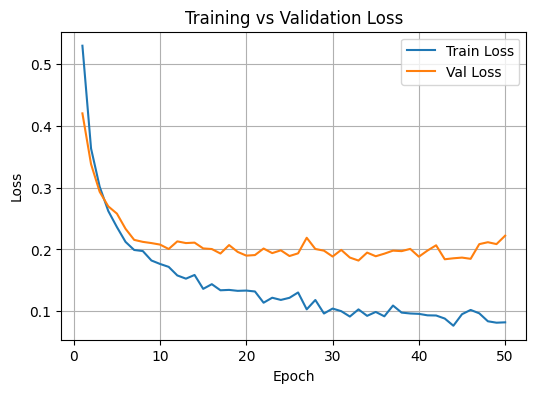

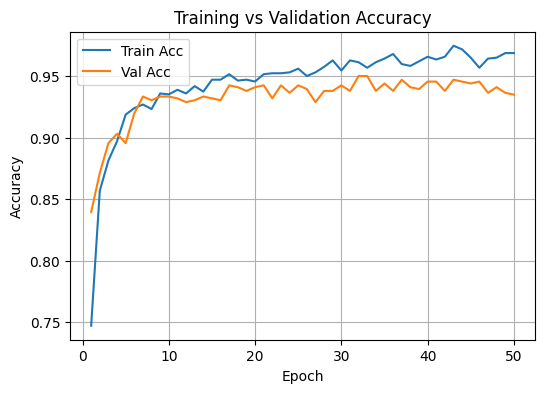

In [152]:
loss_history_1 = train_and_plot(0.1,50, 32)

Epoch 1
-------------------------------
loss: 0.690191  [  160/ 1340]
loss: 0.607414  [  320/ 1340]
loss: 0.718829  [  480/ 1340]
loss: 0.587666  [  640/ 1340]
loss: 0.658577  [  800/ 1340]
loss: 0.599897  [  960/ 1340]
loss: 0.620031  [ 1120/ 1340]
loss: 0.557708  [ 1280/ 1340]
Test Error: 
 Accuracy: 67.0%, Avg loss: 0.618187 

Epoch 2
-------------------------------
loss: 0.623025  [  160/ 1340]
loss: 0.659034  [  320/ 1340]
loss: 0.656885  [  480/ 1340]
loss: 0.569620  [  640/ 1340]
loss: 0.623503  [  800/ 1340]
loss: 0.518789  [  960/ 1340]
loss: 0.584475  [ 1120/ 1340]
loss: 0.643372  [ 1280/ 1340]
Test Error: 
 Accuracy: 74.5%, Avg loss: 0.570432 

Epoch 3
-------------------------------
loss: 0.513340  [  160/ 1340]
loss: 0.548963  [  320/ 1340]
loss: 0.548169  [  480/ 1340]
loss: 0.594589  [  640/ 1340]
loss: 0.511983  [  800/ 1340]
loss: 0.582358  [  960/ 1340]
loss: 0.498403  [ 1120/ 1340]
loss: 0.502380  [ 1280/ 1340]
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.533859 

Epoc

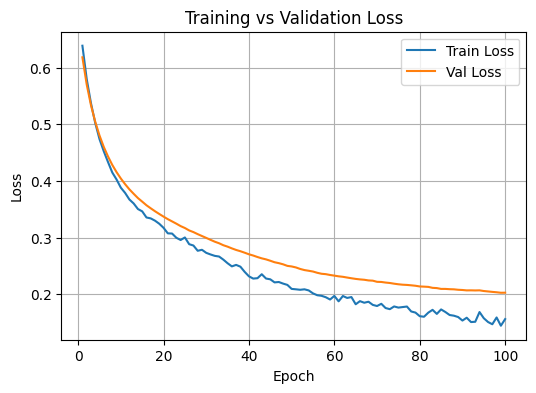

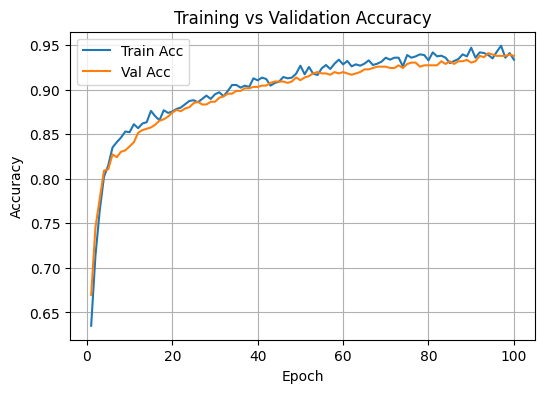

In [153]:
loss_history_2 = train_and_plot(0.01,100,32)

Epoch 1
-------------------------------
loss: 0.687480  [  160/ 1340]
loss: 0.752915  [  320/ 1340]
loss: 0.753406  [  480/ 1340]
loss: 0.704264  [  640/ 1340]
loss: 0.647758  [  800/ 1340]
loss: 0.707387  [  960/ 1340]
loss: 0.695532  [ 1120/ 1340]
loss: 0.699341  [ 1280/ 1340]
Test Error: 
 Accuracy: 54.8%, Avg loss: 0.682614 

Epoch 2
-------------------------------
loss: 0.744767  [  160/ 1340]
loss: 0.704844  [  320/ 1340]
loss: 0.613868  [  480/ 1340]
loss: 0.706558  [  640/ 1340]
loss: 0.690079  [  800/ 1340]
loss: 0.665328  [  960/ 1340]
loss: 0.654369  [ 1120/ 1340]
loss: 0.649605  [ 1280/ 1340]
Test Error: 
 Accuracy: 56.5%, Avg loss: 0.674196 

Epoch 3
-------------------------------
loss: 0.660406  [  160/ 1340]
loss: 0.730911  [  320/ 1340]
loss: 0.716493  [  480/ 1340]
loss: 0.662595  [  640/ 1340]
loss: 0.710365  [  800/ 1340]
loss: 0.671743  [  960/ 1340]
loss: 0.702327  [ 1120/ 1340]
loss: 0.656127  [ 1280/ 1340]
Test Error: 
 Accuracy: 58.9%, Avg loss: 0.666226 

Epoc

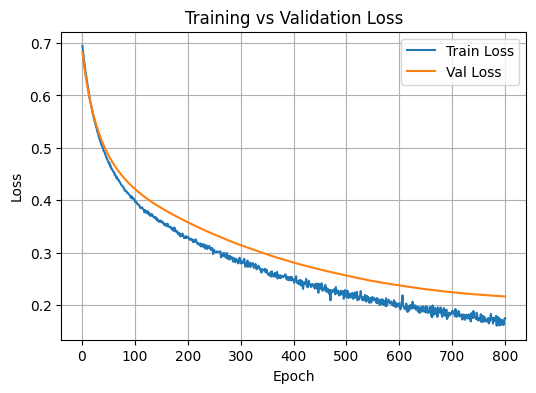

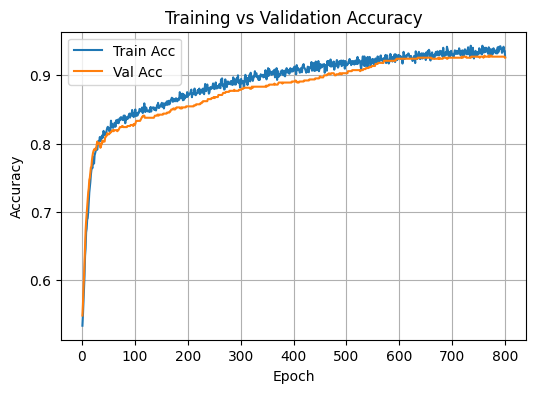

In [130]:
# Lower LR a bit to reduce training loss jitter.
loss_history_3 = train_and_plot(0.001,800,32)

In [131]:
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ReduceLROnPlateau

In [132]:
# keep LR=0.01 but use Adam/AdamW and a scheduler (e.g., cosine decay or step LR)
def train_and_plot_schedule(lr,epochs, batch_size, scheduler_class):
    model = oneResidualBlock()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    if scheduler_class == StepLR:
        scheduler = scheduler_class(optimizer, step_size=30, gamma=0.1)
    elif scheduler_class == CosineAnnealingLR:
        scheduler = CosineAnnealingLR(optimizer, T_max=50)  # restart after 50 epochs
    elif scheduler_class == ReduceLROnPlateau:
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    loss_history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        loss_train, accuracy_train = training_loop(X_train, y_train, batch_size, model, optimizer, criterion)
        loss_epoch, accuracy_epoch = evaluation_loop(X_test, y_test, batch_size, model, criterion)
        if scheduler_class == ReduceLROnPlateau:
            # for ReduceLROnPlateau:
            scheduler.step(loss_epoch)
        else:
            scheduler.step()
        lr_now = optimizer.param_groups[0]['lr']
        print(f"Epoch {t}, LR={lr_now}")
        loss_history["train_loss"].append(loss_train)
        loss_history["train_acc"].append(accuracy_train)
        loss_history["val_loss"].append(loss_epoch)
        loss_history["val_acc"].append(accuracy_epoch)
    
    # - Plot loss vs epoch
    plot_training_curves(loss_history)
    return loss_history

Epoch 1
-------------------------------
loss: 0.546390  [  160/ 1340]
loss: 0.371076  [  320/ 1340]
loss: 0.351040  [  480/ 1340]
loss: 0.236468  [  640/ 1340]
loss: 0.383734  [  800/ 1340]
loss: 0.267535  [  960/ 1340]
loss: 0.110800  [ 1120/ 1340]
loss: 0.254498  [ 1280/ 1340]
Test Error: 
 Accuracy: 90.5%, Avg loss: 0.247873 

Epoch 0, LR=0.01
Epoch 2
-------------------------------
loss: 0.211335  [  160/ 1340]
loss: 0.419837  [  320/ 1340]
loss: 0.128061  [  480/ 1340]
loss: 0.085070  [  640/ 1340]
loss: 0.123603  [  800/ 1340]
loss: 0.340608  [  960/ 1340]
loss: 0.206281  [ 1120/ 1340]
loss: 0.215602  [ 1280/ 1340]
Test Error: 
 Accuracy: 92.9%, Avg loss: 0.214323 

Epoch 1, LR=0.01
Epoch 3
-------------------------------
loss: 0.120699  [  160/ 1340]
loss: 0.304053  [  320/ 1340]
loss: 0.254341  [  480/ 1340]
loss: 0.214029  [  640/ 1340]
loss: 0.174347  [  800/ 1340]
loss: 0.187457  [  960/ 1340]
loss: 0.122609  [ 1120/ 1340]
loss: 0.125500  [ 1280/ 1340]
Test Error: 
 Accuracy

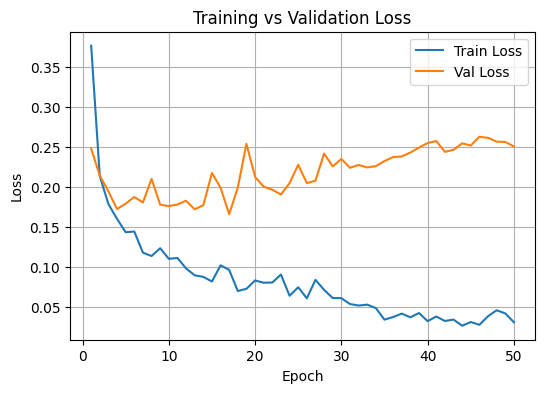

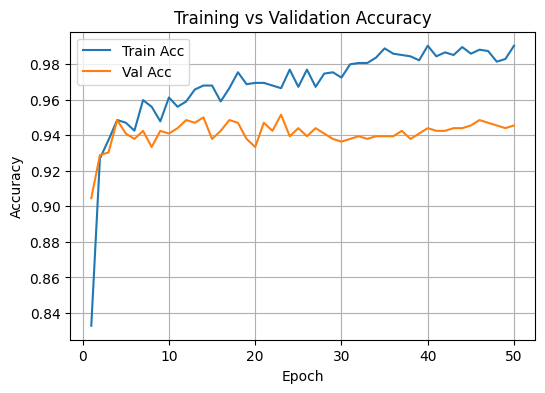

In [133]:
loss_history_schedule_1 = train_and_plot_schedule(0.01,50,32,StepLR)

Epoch 1
-------------------------------
loss: 0.682198  [  160/ 1340]
loss: 0.519508  [  320/ 1340]
loss: 0.373024  [  480/ 1340]
loss: 0.343492  [  640/ 1340]
loss: 0.326087  [  800/ 1340]
loss: 0.396070  [  960/ 1340]
loss: 0.093343  [ 1120/ 1340]
loss: 0.155708  [ 1280/ 1340]
Test Error: 
 Accuracy: 90.3%, Avg loss: 0.259243 

Epoch 0, LR=0.009990133642141357
Epoch 2
-------------------------------
loss: 0.206604  [  160/ 1340]
loss: 0.153871  [  320/ 1340]
loss: 0.091781  [  480/ 1340]
loss: 0.191639  [  640/ 1340]
loss: 0.186344  [  800/ 1340]
loss: 0.111849  [  960/ 1340]
loss: 0.264433  [ 1120/ 1340]
loss: 0.070855  [ 1280/ 1340]
Test Error: 
 Accuracy: 93.8%, Avg loss: 0.194709 

Epoch 1, LR=0.009960573506572389
Epoch 3
-------------------------------
loss: 0.148561  [  160/ 1340]
loss: 0.110742  [  320/ 1340]
loss: 0.139837  [  480/ 1340]
loss: 0.158802  [  640/ 1340]
loss: 0.172267  [  800/ 1340]
loss: 0.089943  [  960/ 1340]
loss: 0.072798  [ 1120/ 1340]
loss: 0.270915  [ 12

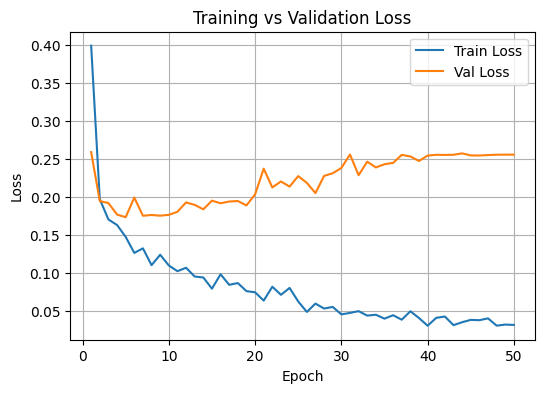

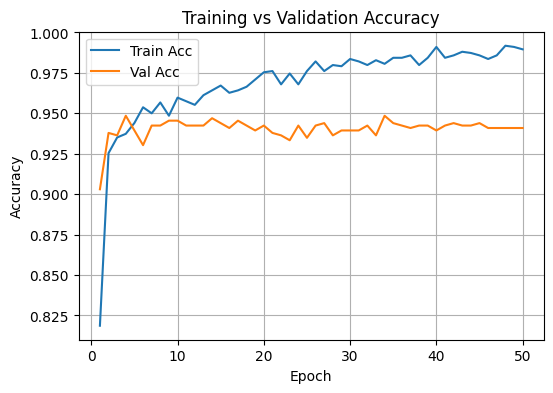

In [134]:
loss_history_schedule_2 = train_and_plot_schedule(0.01,50,32,CosineAnnealingLR)

Epoch 1
-------------------------------
loss: 0.566036  [  160/ 1340]
loss: 0.395564  [  320/ 1340]
loss: 0.364465  [  480/ 1340]
loss: 0.275417  [  640/ 1340]
loss: 0.302568  [  800/ 1340]
loss: 0.195838  [  960/ 1340]
loss: 0.369775  [ 1120/ 1340]
loss: 0.272448  [ 1280/ 1340]
Test Error: 
 Accuracy: 90.5%, Avg loss: 0.240709 

Epoch 0, LR=0.01
Epoch 2
-------------------------------
loss: 0.209806  [  160/ 1340]
loss: 0.132270  [  320/ 1340]
loss: 0.316692  [  480/ 1340]
loss: 0.099460  [  640/ 1340]
loss: 0.235539  [  800/ 1340]
loss: 0.178028  [  960/ 1340]
loss: 0.178119  [ 1120/ 1340]
loss: 0.171556  [ 1280/ 1340]
Test Error: 
 Accuracy: 92.7%, Avg loss: 0.205486 

Epoch 1, LR=0.01
Epoch 3
-------------------------------
loss: 0.223662  [  160/ 1340]
loss: 0.117843  [  320/ 1340]
loss: 0.091614  [  480/ 1340]
loss: 0.177991  [  640/ 1340]
loss: 0.131835  [  800/ 1340]
loss: 0.101673  [  960/ 1340]
loss: 0.074934  [ 1120/ 1340]
loss: 0.315781  [ 1280/ 1340]
Test Error: 
 Accuracy

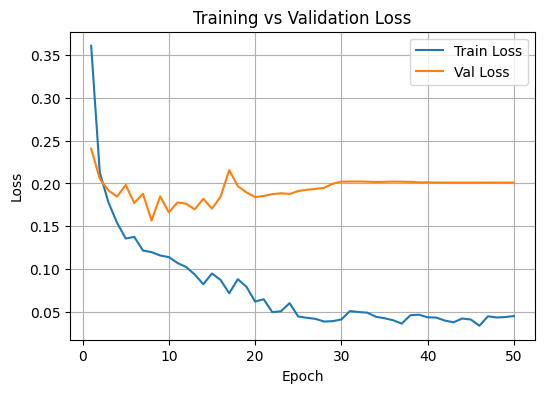

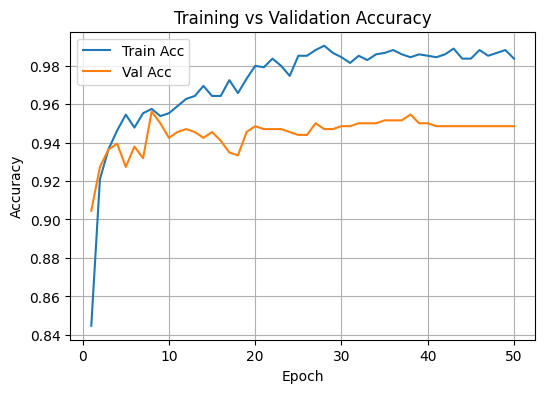

In [135]:
loss_history_schedule_3 = train_and_plot_schedule(0.01,50,32,ReduceLROnPlateau)

Other regularization tips

Add weight decay (AdamW): optim.AdamW(..., weight_decay=1e-4).

Increase dropout in blocks (e.g., 0.3–0.5) and see if val improves.

Shrink the model a bit (fewer blocks or smaller hidden) to reduce overfit.